# Land Cover Type Classification with PyTorch

This notebook serves as a starting point for your machine learning project on land cover type classification.

The task at hand involves classifying land cover types, such as 'Forest,' 'River,' 'Highway,' and more, based on satellite images. The dataset consists of images labeled with their corresponding land cover types. The goal is to train a machine learning model that can accurately predict the land cover type of new, unseen images.

In this notebook, you'll find code snippets to load and visualize the data, providing insights into the images and their labels.

## Build Your Model

You have the freedom to choose the architecture or model for your land cover classification task. Whether you opt for a simple convolutional neural network (CNN) or explore transfer learning with pre-trained models, the notebook provides a flexible starting point. Experiment with different architectures to achieve the best performance.

## Model Training and Evaluation

Once your model is defined, the notebook guides you through the process of training it on the dataset. Additionally, it includes code to evaluate the model's performance on the validation and test sets.

Feel free to modify, experiment, and enhance the provided code. Happy coding !

Please submit your weekly assignments to me via [email](mailto:elmontassir@cerfacs.fr) to receive your score on the test set.



# Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [3]:
# Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/TEST.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2023-12-29 16:44:05 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar" [1]
2023-12-29 16:44:08 URL:https://cerfacs.fr/opendata/cours/data/TEST.tar [15687680/15687680] -> "TEST.tar" [1]
2023-12-29 16:44:10 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy" [1]


In [4]:
# Using tarfile to create np arrays
def extract_files(dataset):
    tar = tarfile.open(dataset+'.tar', 'r')
    names = tar.getmembers()[:]
    images = [tar.extractfile(name) for name in names]
    return np.array([np.array(Image.open(image)) for image in images])

In [5]:
X_train = extract_files('TRAIN')
X_test = extract_files('TEST')
y_train = np.load('y_train.npy').reshape(-1, 1)
print("Train data : ",X_train.shape)
print("Train labels", y_train.shape)
print("Test data : ",X_test.shape)

Train data :  (20000, 64, 64, 3)
Train labels (20000, 1)
Test data :  (7000, 64, 64, 3)


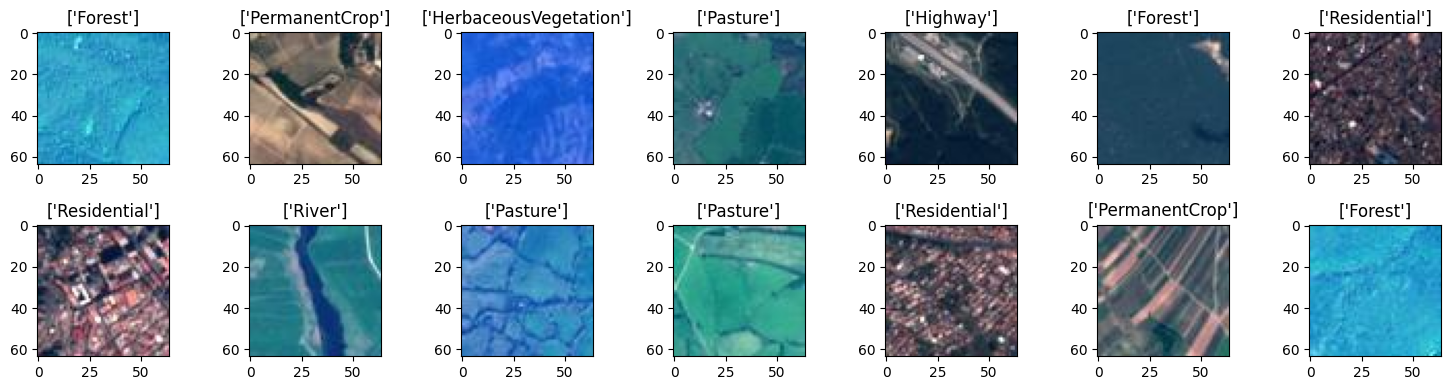

In [6]:
# Display data samples
fig, axes = plt.subplots(2, 7, figsize=(15, 4))
axes = axes.ravel()
for i in range(14):
    axes[i].imshow(X_train[i])
    axes[i].set_title(y_train[i])
plt.tight_layout()

In [7]:
# Assuming X_train and y_train are PyTorch tensors
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

There are 10 possible classes for each image (only one per image is correct):

  - 'AnnualCrop'
  - 'Forest'
  - 'HerbaceousVegetation'
  - 'Highway'
  - 'Industrial'
  - 'Pasture'
  - 'PermanentCrop'
  - 'Residential'
  - 'River'
  - 'SeaLake'

We could simply code an integer value for each: 'AnnualCrop' = 0, 'Forest' = 1, etc... This is known as "Ordinal Encoding", and has some drawbacks, e.g. if the network is unsure whether it is class 0 or 2, it could end up saying 1, which is another class altogether. When categories have a natural order, ordinal encoding can be a good way to go. Here, this is not the case.

The most classical way to convert the type of labels here to numeric values is through [**one-hot encoding**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features). In this process, the label is converted to a vector with length the number of possible labels, and only the one matching the true label is set to 1, all others are set to 0.

|                 | Type1 | Type2 | Type3 |   | Label Vector |
|-----------------|:-----:|:-----:|:-----:|---|:------------:|
| Sample1: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample2: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample3: Type 1 |   1   |   0   |   0   |   |   [1, 0, 0]  |
| ...             |       |       |       |   |              |

Scikit-learn has a useful class for this, [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which does this automatically. More importantly, it remembers the encoding, and you can use it again after making your final predictions te *decode* them back to text labels, as expected by the competition.

In [8]:
# Convert labels to one-hot encoding
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()
y_valid = encoder.fit_transform(y_valid).toarray()

# Model

Note: the images here are encoded with 8-bit integers, *i.e.* between 0 and 255. A normalization is needed.

In [9]:
# # Prepare data for training
# X_train, X_test = X_train/255, X_test/255
# mean = np.mean(X_train, axis=(0, 1, 2))
# std = np.std(X_train, axis=(0, 1, 2))
# print(mean)
# print(std)

The normalization coefficients for the mean and standard deviation are commonly used for image data normalization within the range of [0, 255] or [0, 1]. This process brings pixel values into a standard range centered around zero, facilitating the acceleration of neural network training. In this case, we begin by dividing by 255 to scale values to [0, 1]. Subsequently, subtracting the mean centers the range around zero, and dividing by the standard deviation reduces the range to a centered Gaussian distribution, promoting stability.

Normalization coefficients may vary depending on the dataset, image characteristics, and network architecture. Experimenting with different strategies is common in model development. For specific datasets, calculating the mean and standard deviation directly from the training data can provide a good normalization.

In [10]:
# Convert data to PyTorch tensors and normalize images
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std)
    transforms.Normalize((0.5,), (0.5,))
])

In [11]:
# Convert the uint8 array to PIL Images
def np2pil(img_array):
    p_img = []
    for i_a in img_array:
        p_i = Image.fromarray(np.uint8(i_a))
        p_img.append(p_i)
    return p_img

X_train_PIL = np2pil(X_train[:])
X_valid_PIL = np2pil(X_valid[:])
X_test_PIL = np2pil(X_test[:])

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_PIL, y_train, test_size=0.2, random_state=42)

In [13]:

X_train_tensor = torch.stack([transform(img) for img in X_train])
X_valid_tensor = torch.stack([transform(img) for img in X_valid])
X_test_tensor = torch.stack([transform(img) for img in X_test_PIL])
# y_train_tensor = torch.from_numpy(y_train)
# y_valid_tensor = torch.from_numpy(y_valid)
y_train_tensor = torch.Tensor(y_train)
y_valid_tensor = torch.Tensor(y_valid)

In [24]:
from torchvision.models.resnet import ResNet101_Weights,ResNet50_Weights
from torchvision import models
from sklearn.metrics import classification_report

# Define the simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, nb_class = 10):
        super(SimpleCNN, self).__init__()
        # self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        # ... (add more layers as needed)
        # self.fc = nn.Linear(..., 10)  # Output has 10 classes
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.rn50 = models.resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)
        self.rn50.fc = nn.Linear(self.rn50.fc.in_features, nb_class)
        # Method1: freezing only one layer, the last one
        # fine_tune_at = 100
        # for param in self.rn50.fc.parameters():
        #   param.requires_grad = False

        # #Freezing the 100 last layers
        # fine_tune_at = 100

        # #Freezing everything
        # for i in range(0,fine_tune_at):
        #   for param in self.rn50.features[i].parameters():
        #     param.requires_grad = False

        # Method 3: freezing all layers execept layer4
        for param in self.rn50.parameters():
          param.requires_grad = True

        for param in self.rn50.layer4.parameters():
          param.requires_grad = False



    def forward(self, x):
        # x = F.relu(self.conv1(x))
        # ... (add forward pass for other layers)
        # YOUR CODE HERE
        # raise NotImplementedError()
        # x = self.fc(x)
        x = self.rn50(x)
        return x

    def set_classification_report(self):
      y_true = [self.id2label[id] for id in all_true]
      y_pred = [self.id2label[id] for id in all_pred]
      self.class_report = f'[INFO] Classification results: \n{classification_report(y_true, y_pred, labels=self.labels)}'



In [25]:
# Instantiate the model
model = SimpleCNN().to(device)

# Print the model architecture
print(model)

# Learning rate
alpha = 0.0001

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# , weight_decay=0.0001
optimizer = optim.Adam(model.parameters(), lr=alpha, weight_decay=0.0001, amsgrad=True)  # You can set learning rate, weight decay, etc.

# Training loop
num_epochs = 23
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

SimpleCNN(
  (rn50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

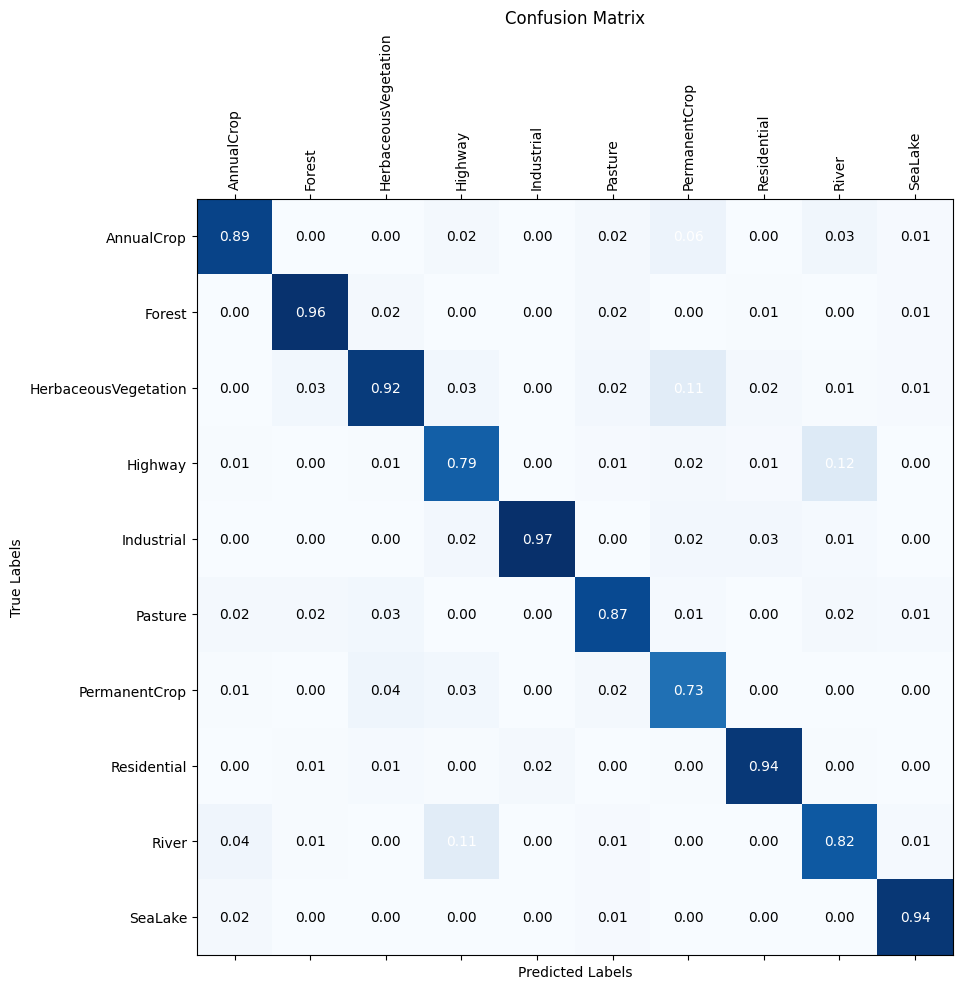

Epoch 1/23, Validation Loss: 0.444, Validation Accuracy: 88.84%, Training Loss: 1.311, Training Accuracy: 60.60%


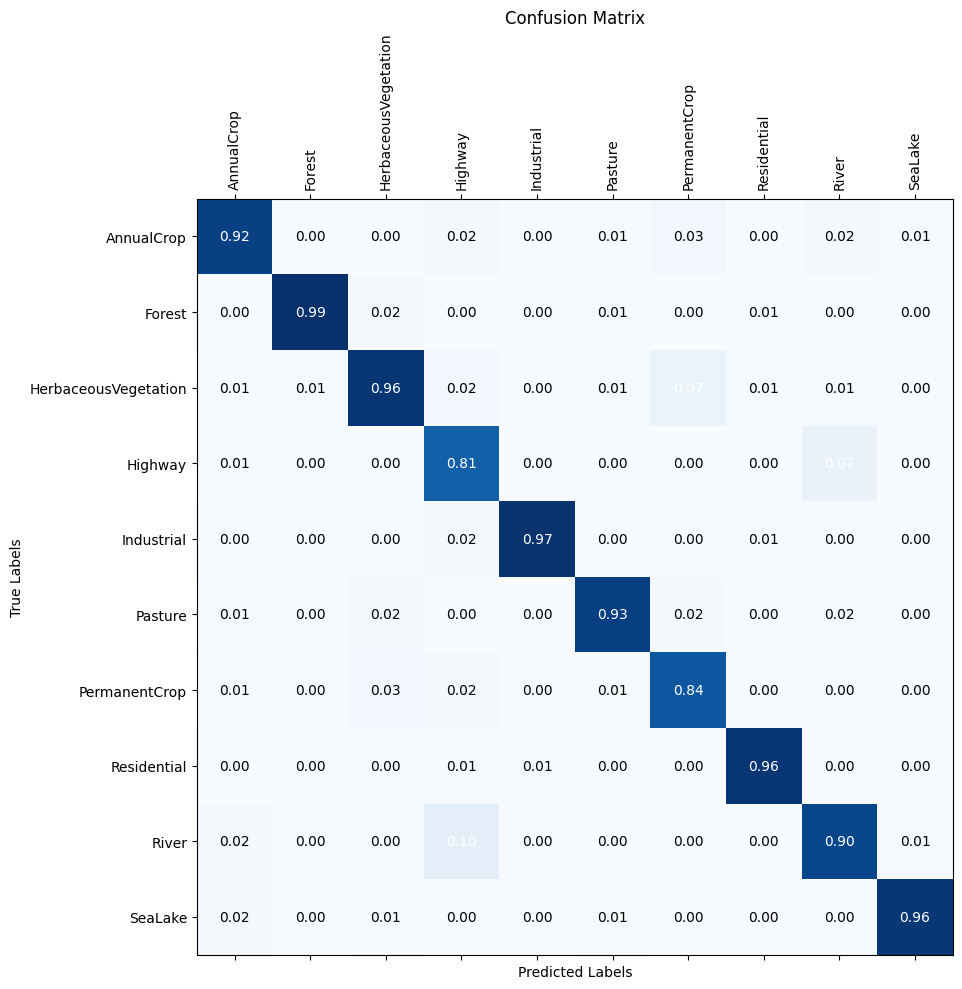

Epoch 2/23, Validation Loss: 0.232, Validation Accuracy: 92.69%, Training Loss: 0.308, Training Accuracy: 91.27%


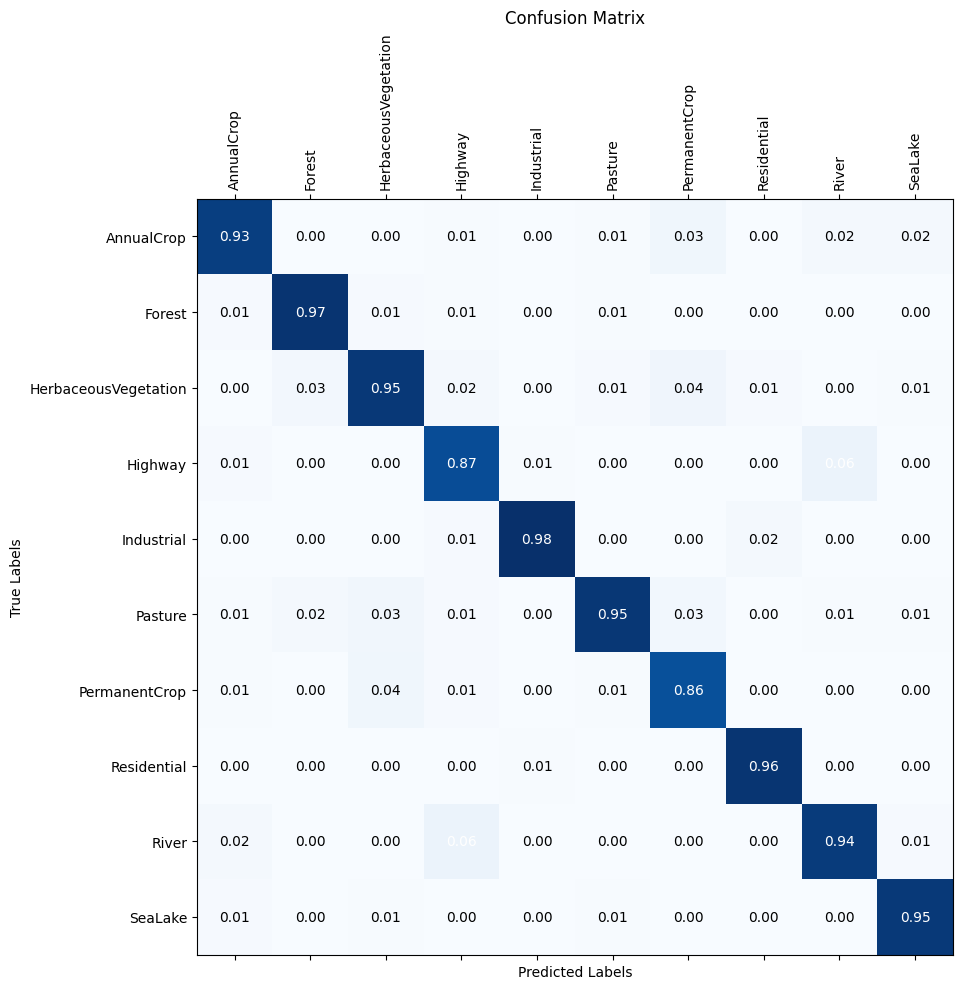

Epoch 3/23, Validation Loss: 0.198, Validation Accuracy: 93.91%, Training Loss: 0.163, Training Accuracy: 95.19%


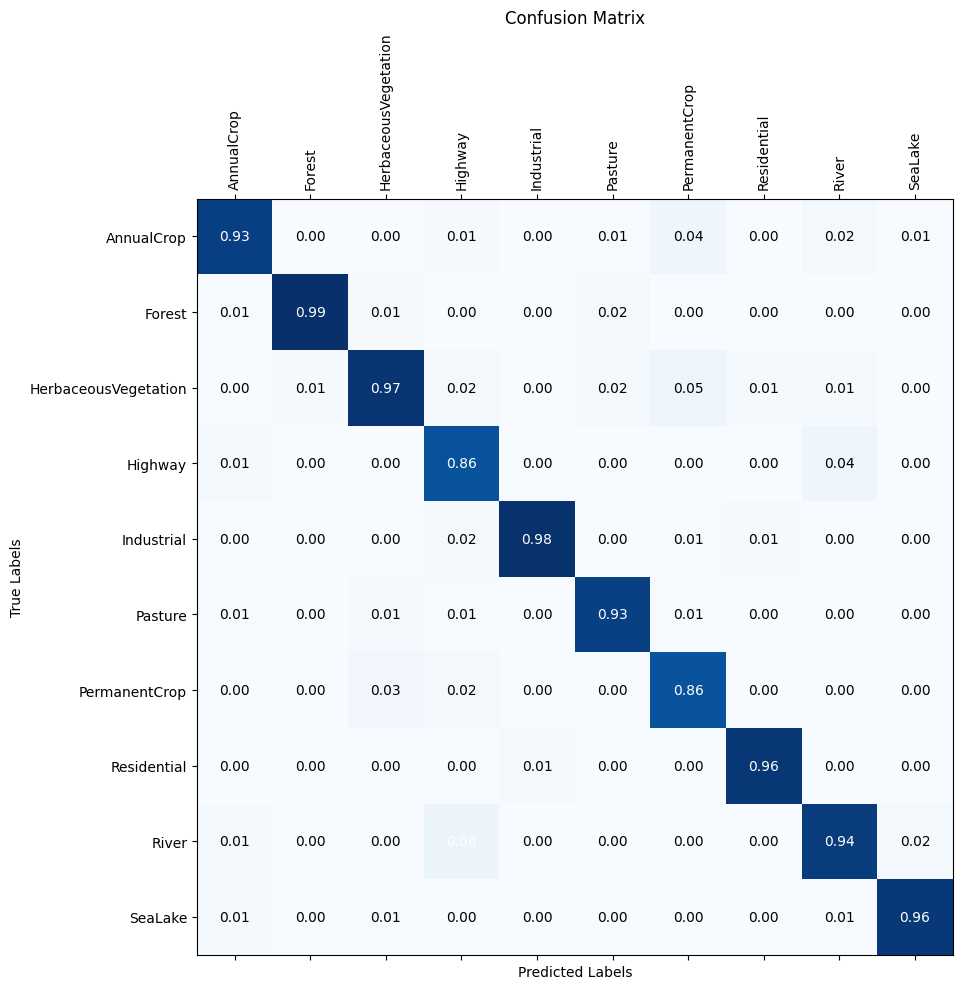

Epoch 4/23, Validation Loss: 0.181, Validation Accuracy: 94.09%, Training Loss: 0.094, Training Accuracy: 97.23%


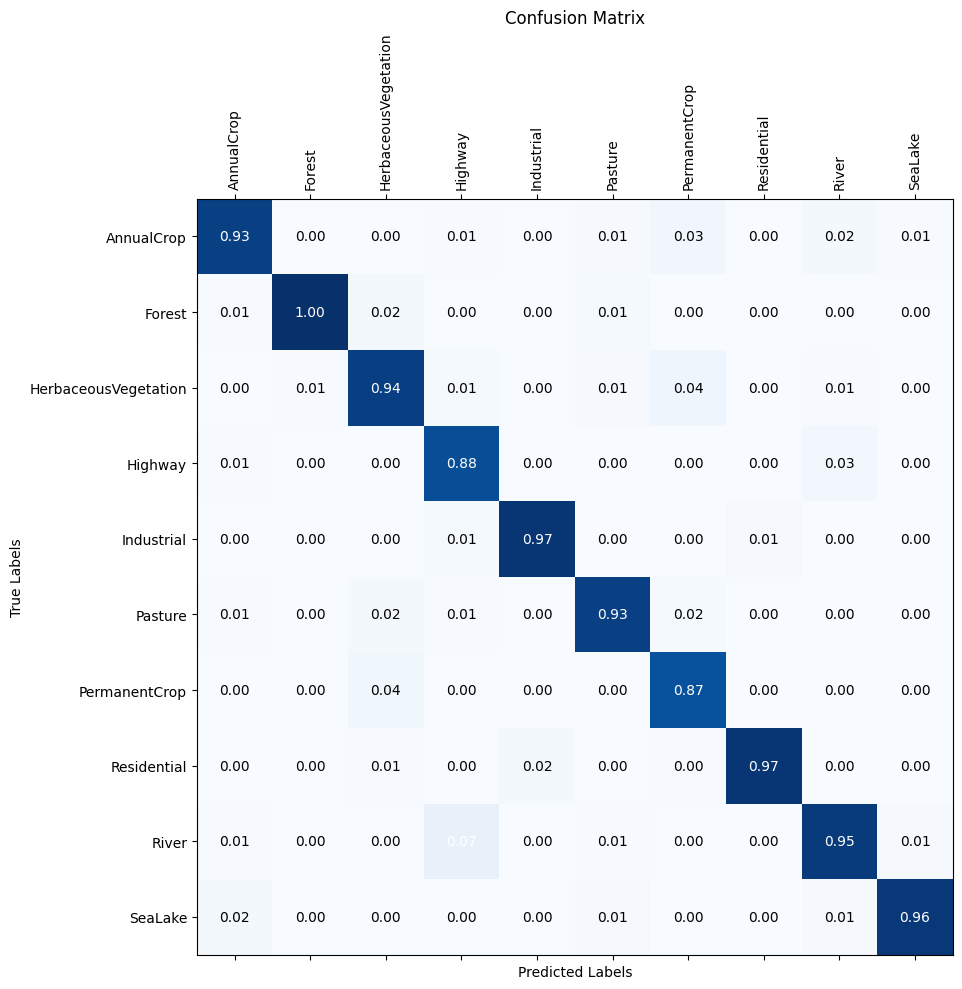

Epoch 5/23, Validation Loss: 0.174, Validation Accuracy: 94.38%, Training Loss: 0.066, Training Accuracy: 98.17%


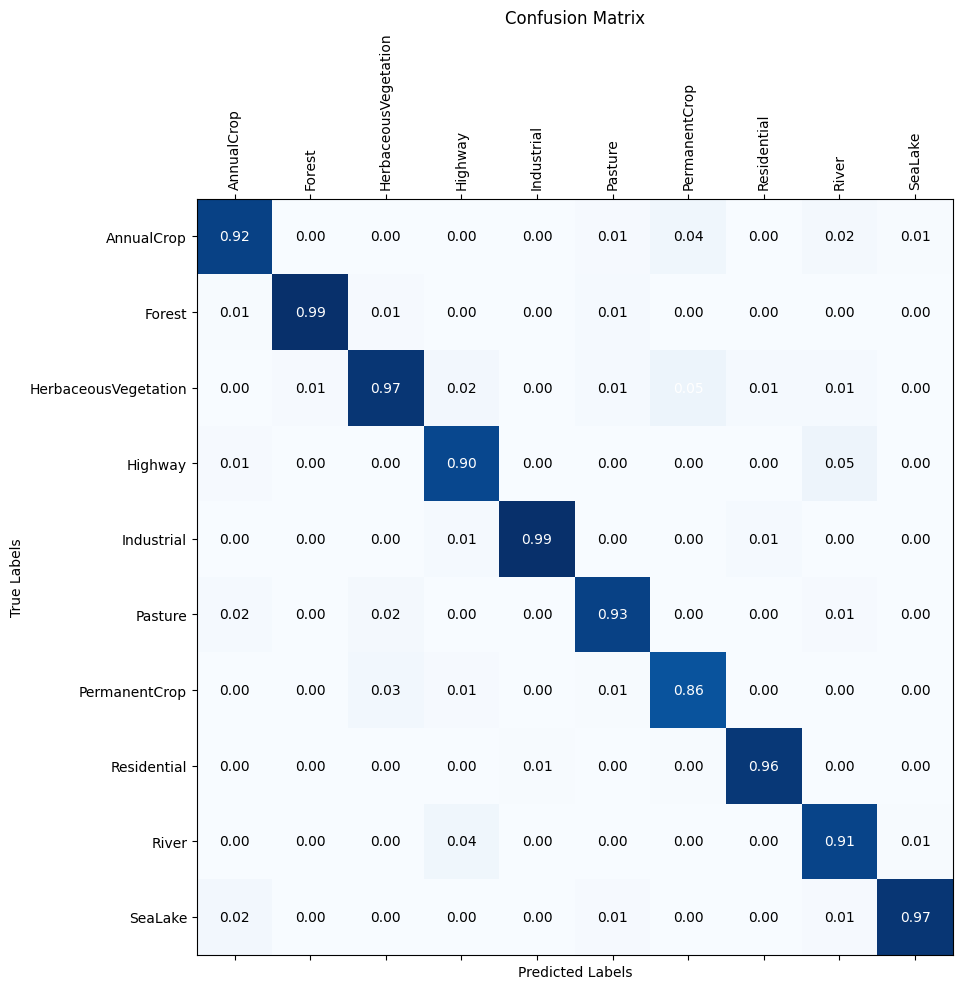

Epoch 6/23, Validation Loss: 0.179, Validation Accuracy: 94.47%, Training Loss: 0.047, Training Accuracy: 98.75%


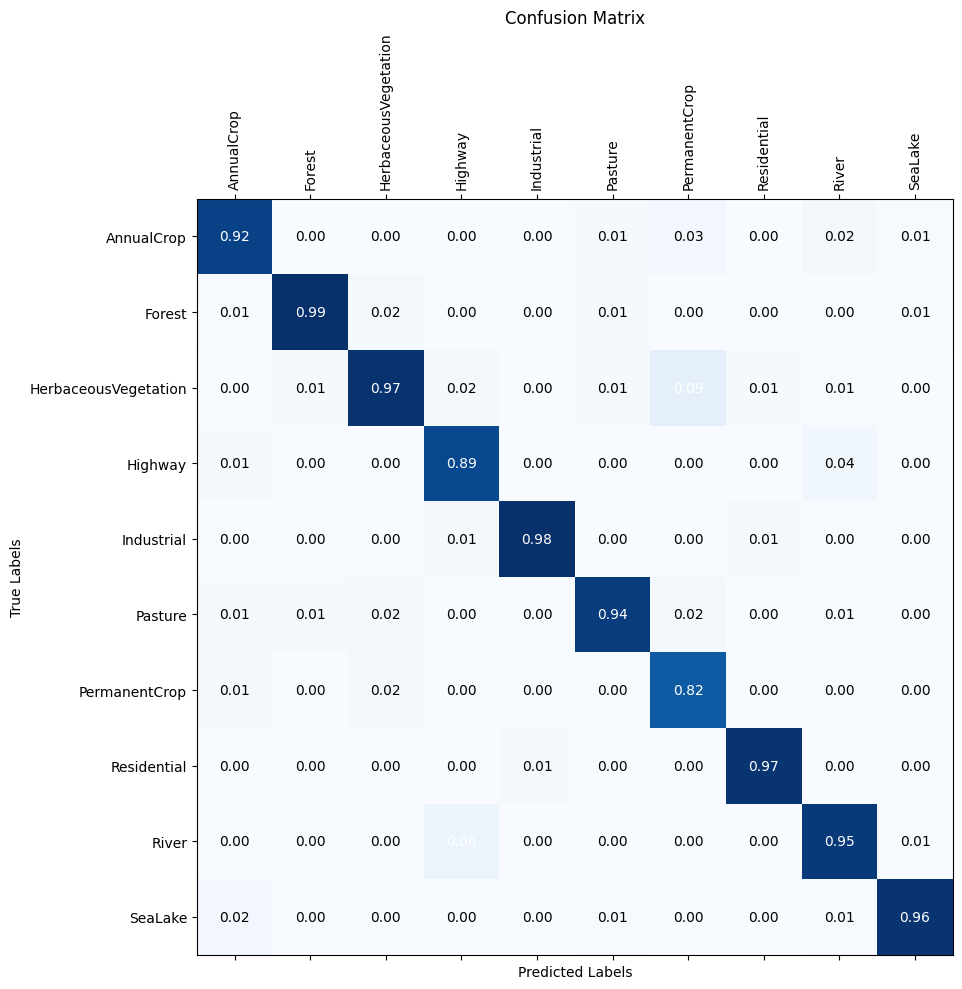

Epoch 7/23, Validation Loss: 0.182, Validation Accuracy: 94.16%, Training Loss: 0.040, Training Accuracy: 98.93%


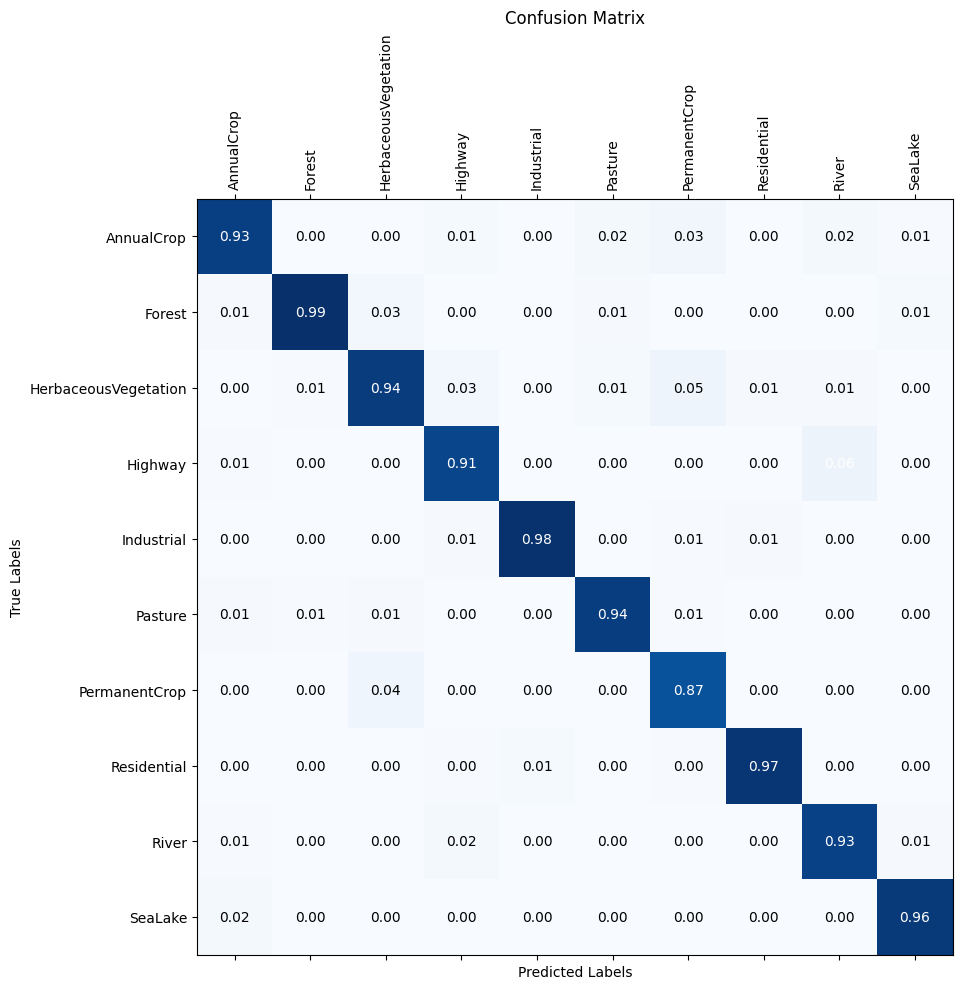

Epoch 8/23, Validation Loss: 0.188, Validation Accuracy: 94.47%, Training Loss: 0.032, Training Accuracy: 99.15%


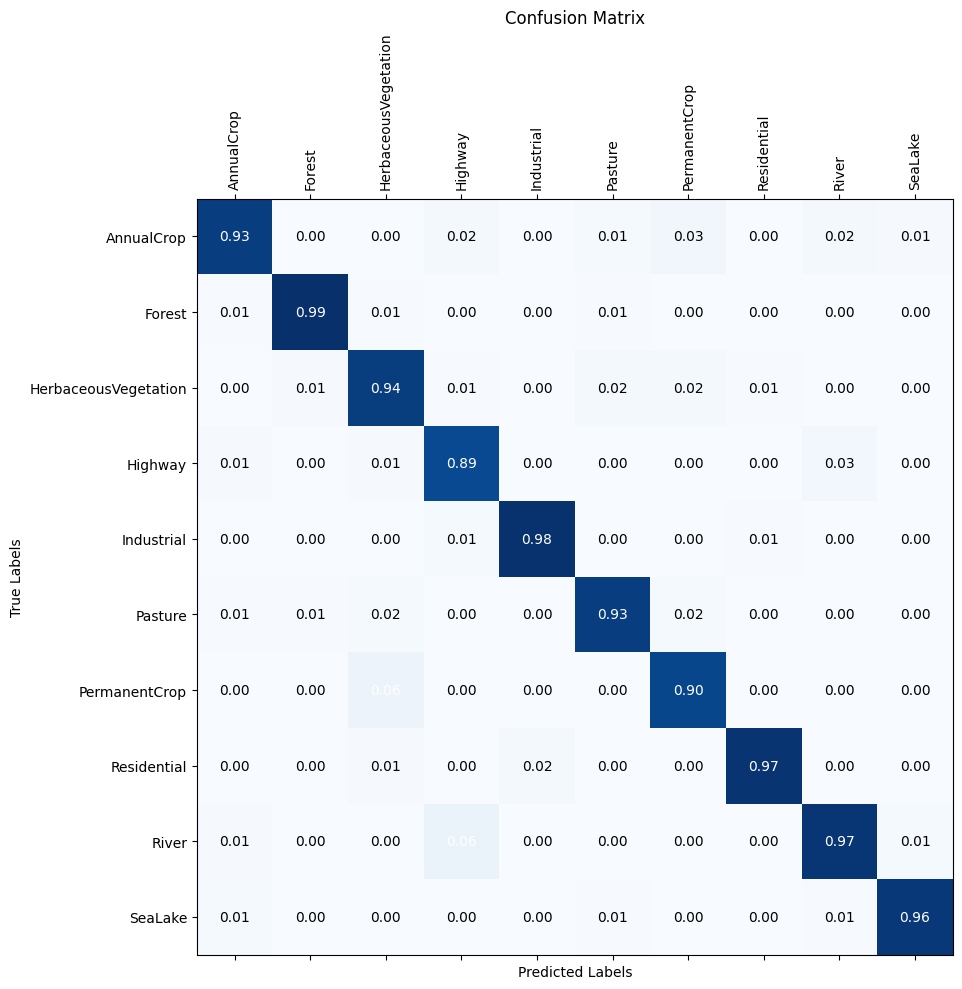

Epoch 9/23, Validation Loss: 0.169, Validation Accuracy: 94.91%, Training Loss: 0.027, Training Accuracy: 99.23%


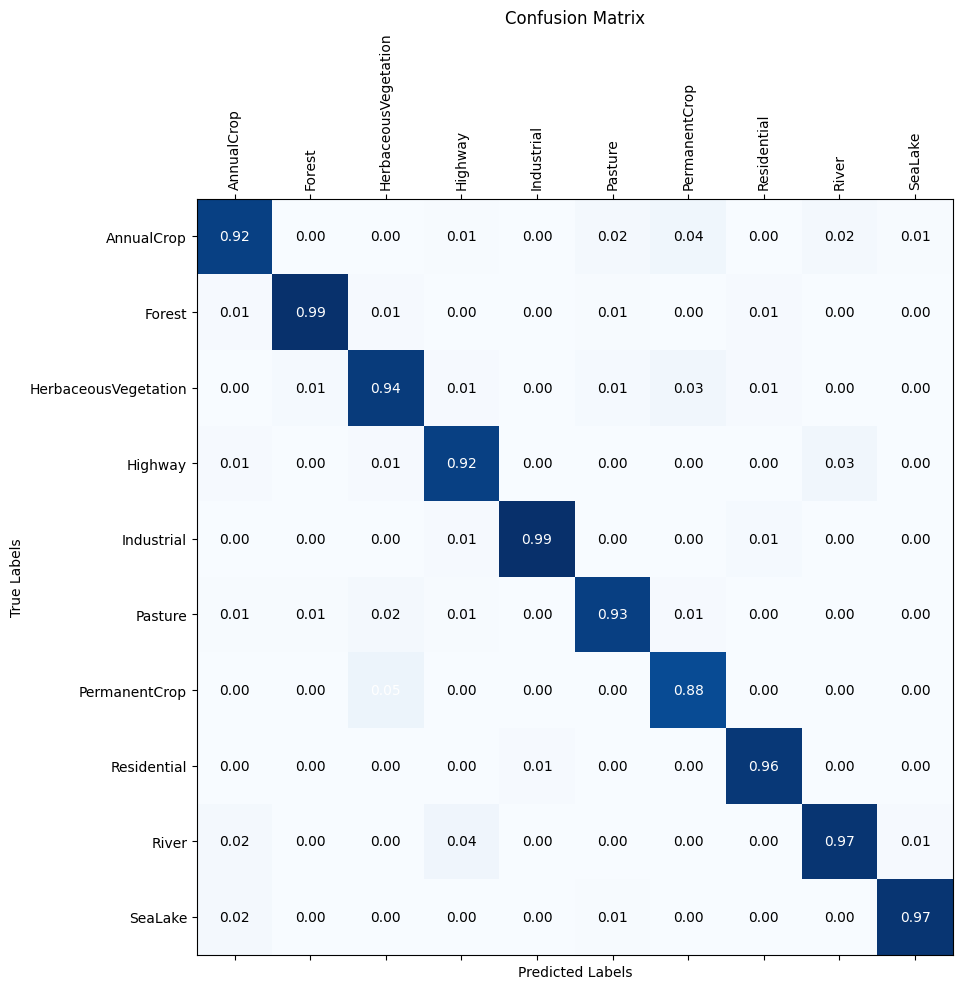

Epoch 10/23, Validation Loss: 0.169, Validation Accuracy: 94.94%, Training Loss: 0.022, Training Accuracy: 99.45%


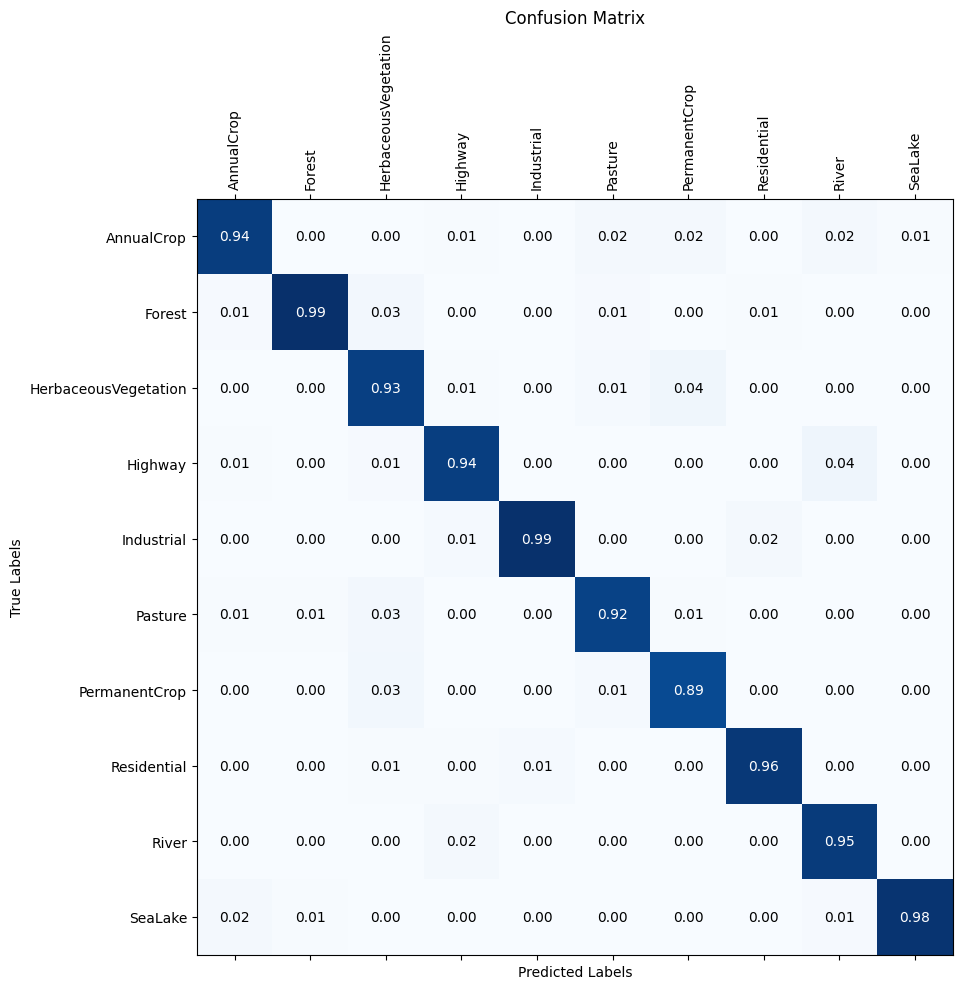

Epoch 11/23, Validation Loss: 0.168, Validation Accuracy: 95.22%, Training Loss: 0.020, Training Accuracy: 99.44%


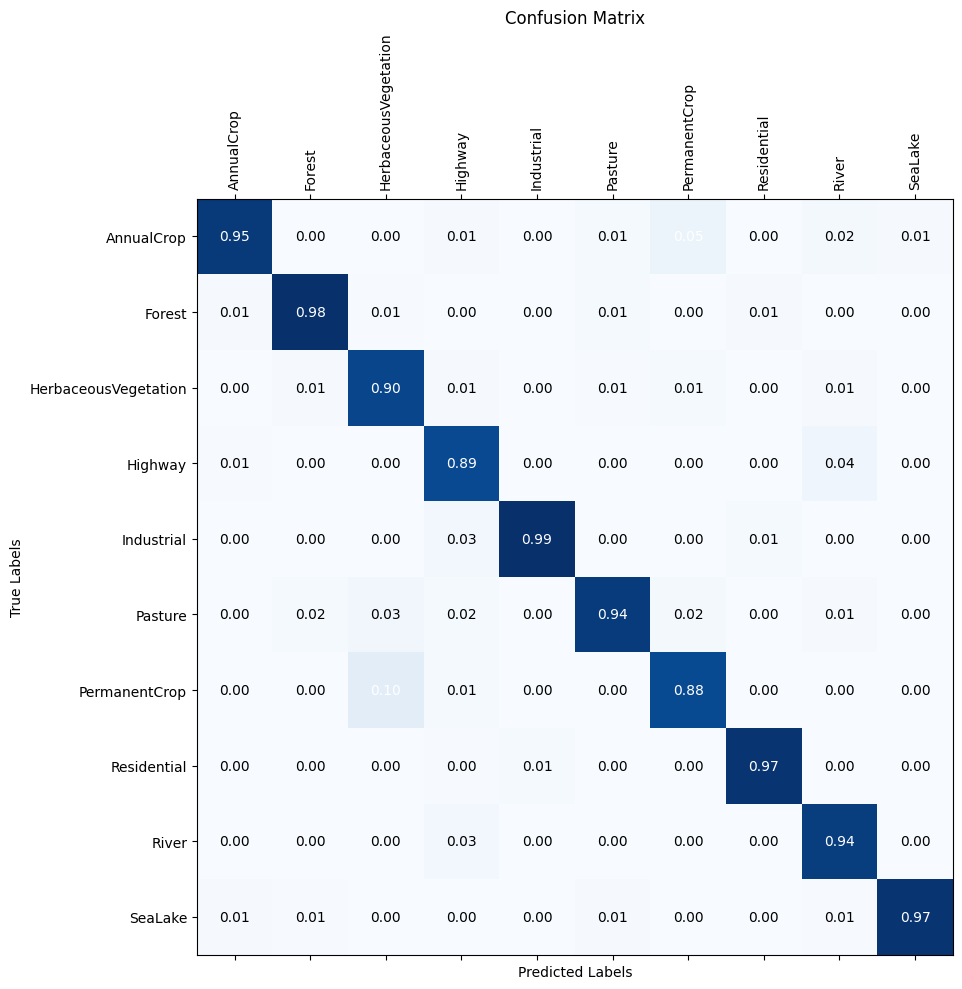

Epoch 12/23, Validation Loss: 0.185, Validation Accuracy: 94.25%, Training Loss: 0.020, Training Accuracy: 99.41%


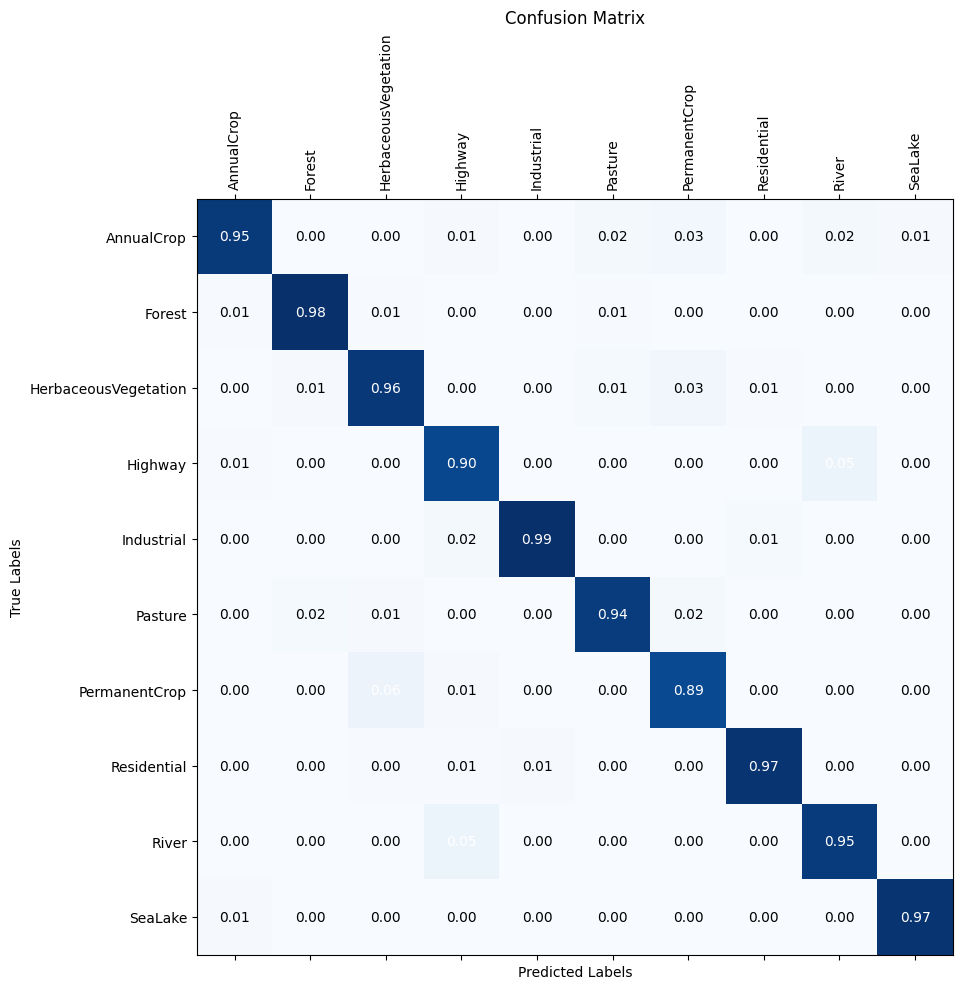

Epoch 13/23, Validation Loss: 0.163, Validation Accuracy: 95.12%, Training Loss: 0.015, Training Accuracy: 99.60%


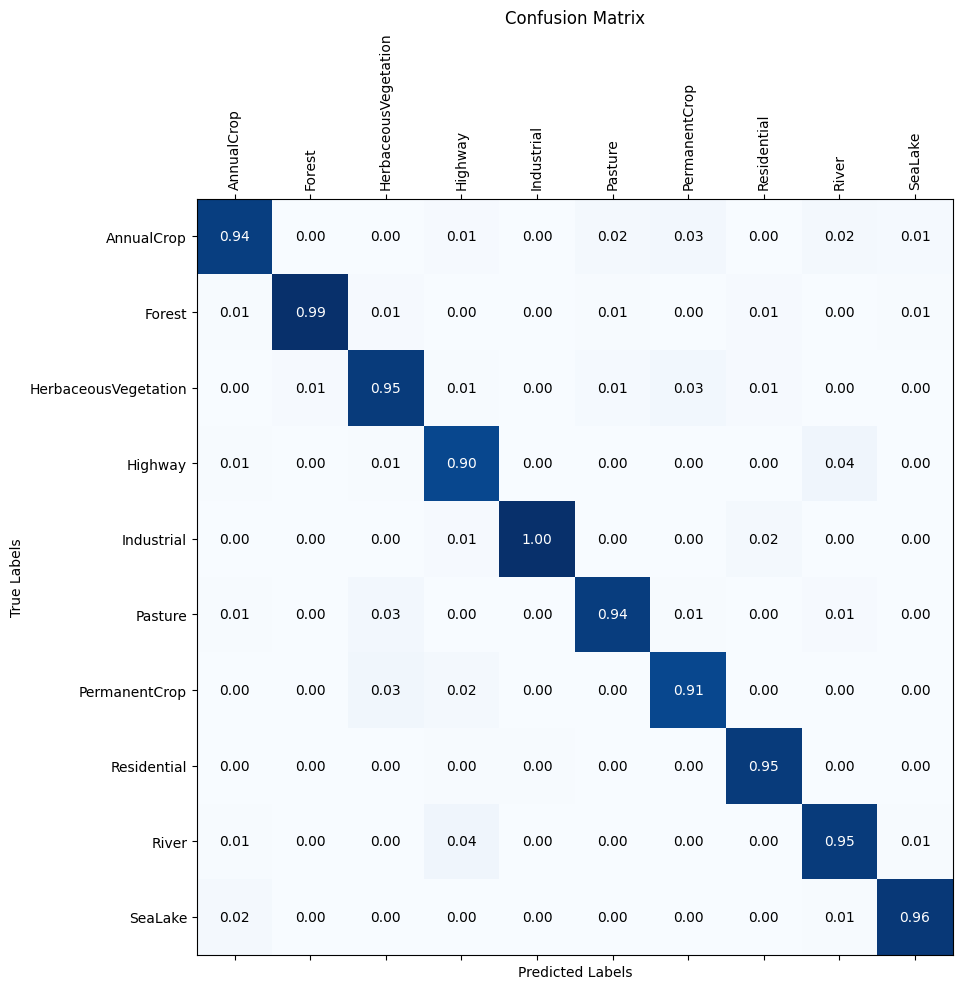

Epoch 14/23, Validation Loss: 0.154, Validation Accuracy: 95.19%, Training Loss: 0.012, Training Accuracy: 99.66%


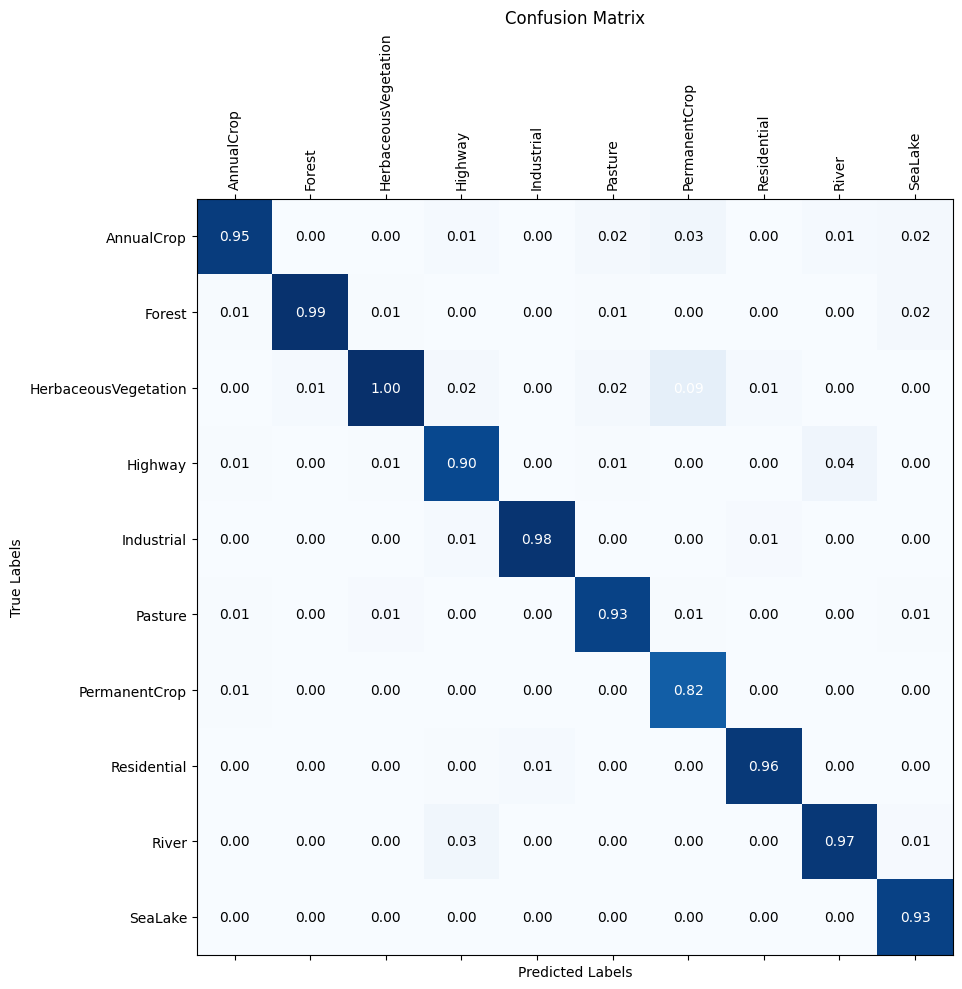

Epoch 15/23, Validation Loss: 0.189, Validation Accuracy: 94.66%, Training Loss: 0.014, Training Accuracy: 99.65%


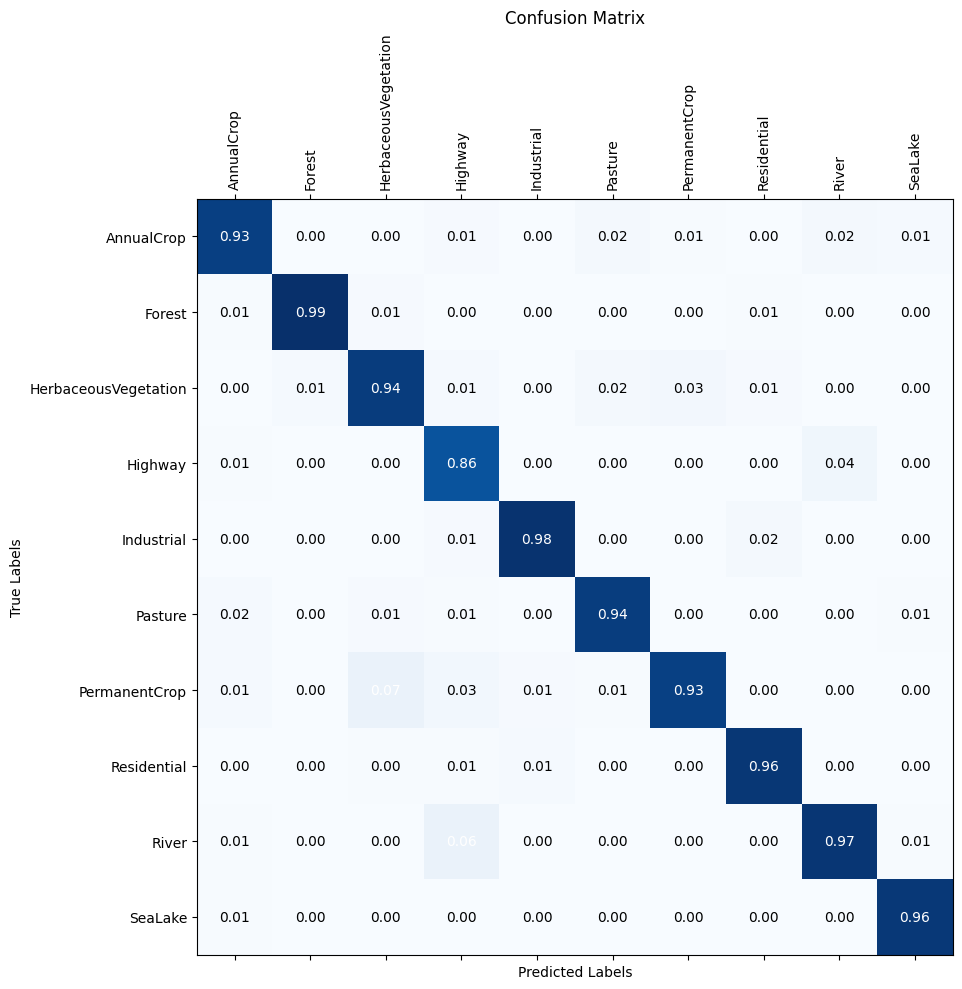

Epoch 16/23, Validation Loss: 0.178, Validation Accuracy: 94.66%, Training Loss: 0.017, Training Accuracy: 99.52%


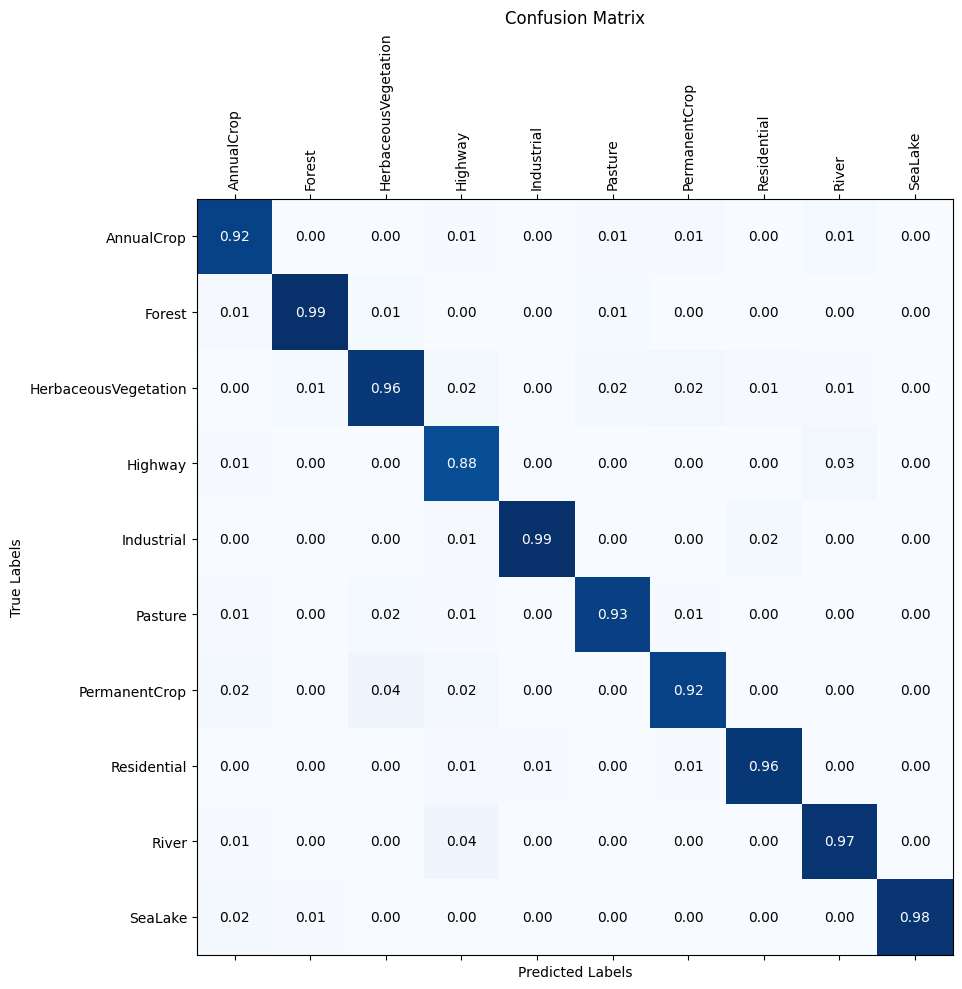

Epoch 17/23, Validation Loss: 0.172, Validation Accuracy: 95.22%, Training Loss: 0.013, Training Accuracy: 99.66%


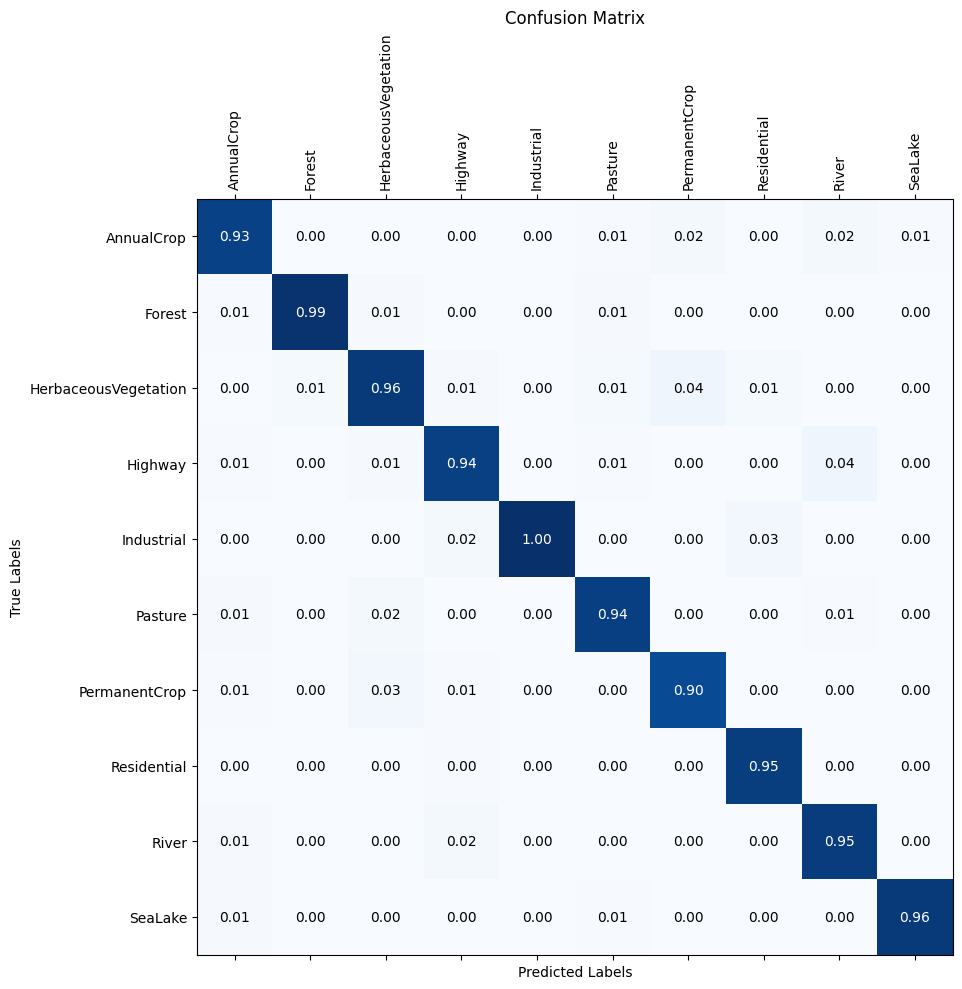

Epoch 18/23, Validation Loss: 0.163, Validation Accuracy: 95.47%, Training Loss: 0.014, Training Accuracy: 99.62%


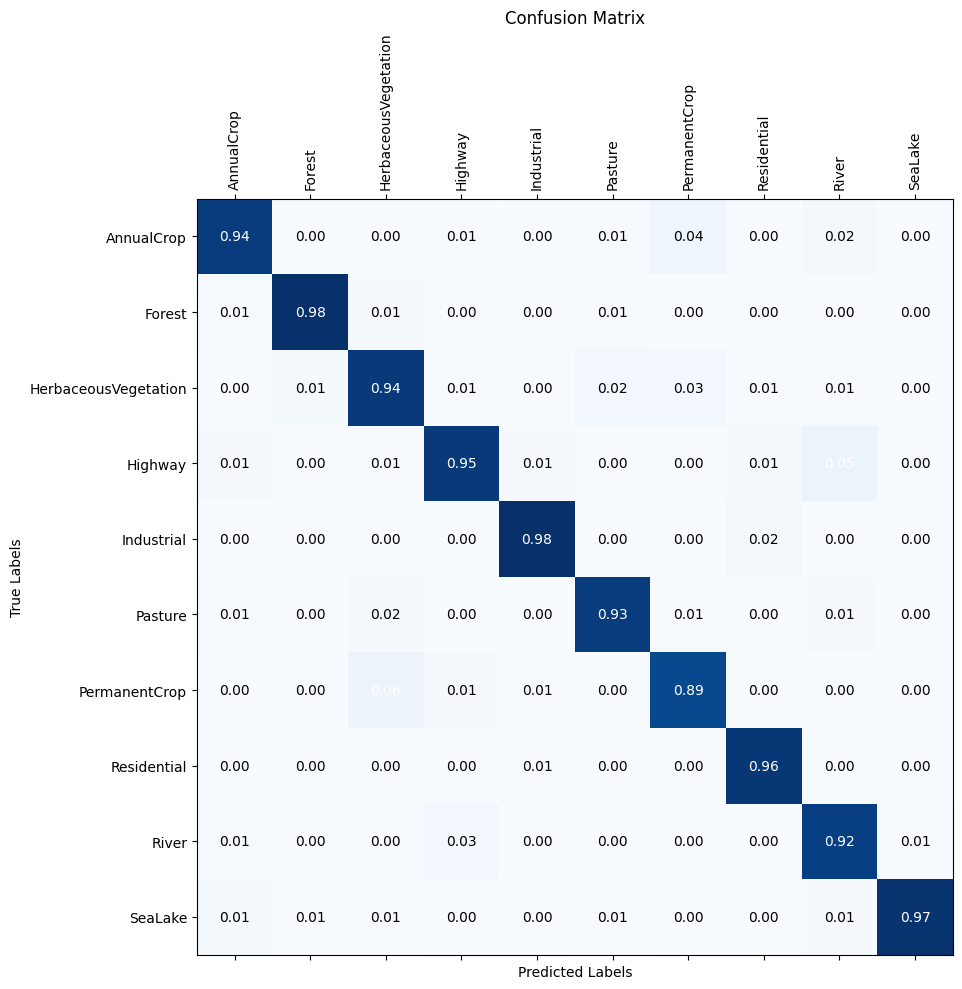

Epoch 19/23, Validation Loss: 0.170, Validation Accuracy: 94.72%, Training Loss: 0.009, Training Accuracy: 99.81%


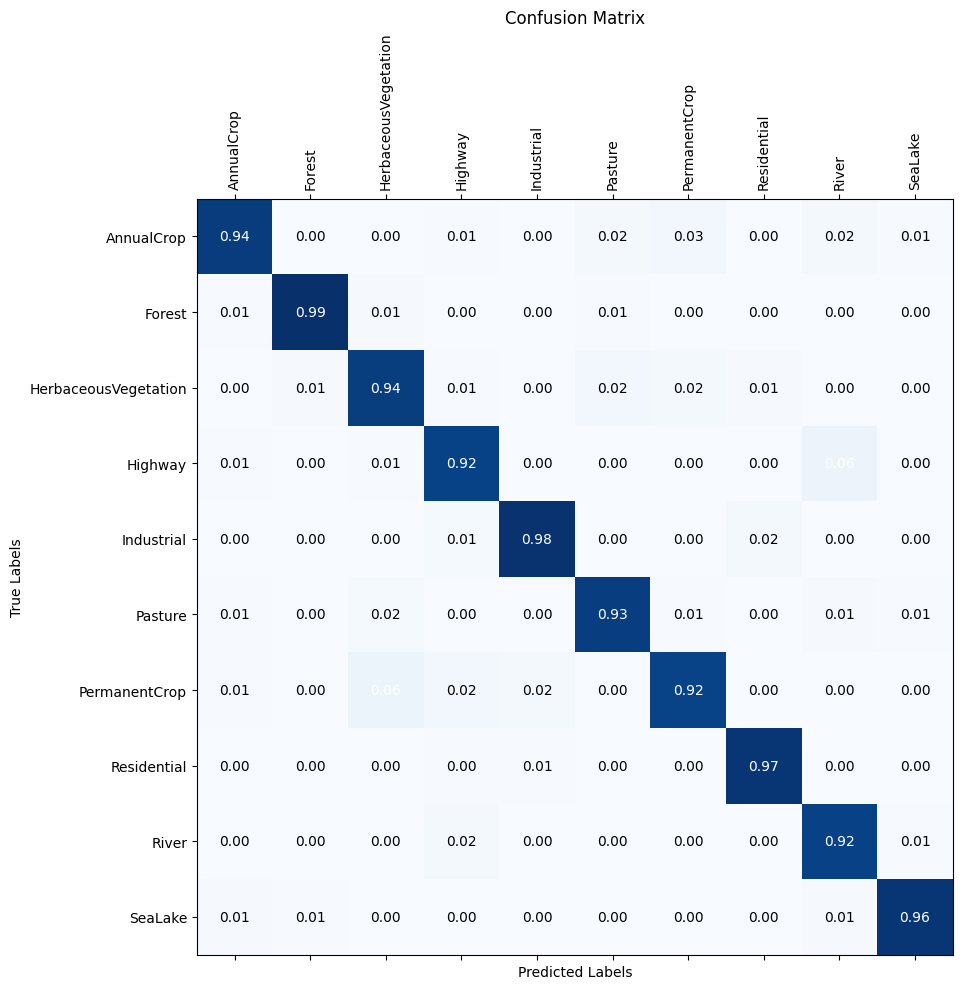

Epoch 20/23, Validation Loss: 0.179, Validation Accuracy: 94.97%, Training Loss: 0.010, Training Accuracy: 99.74%


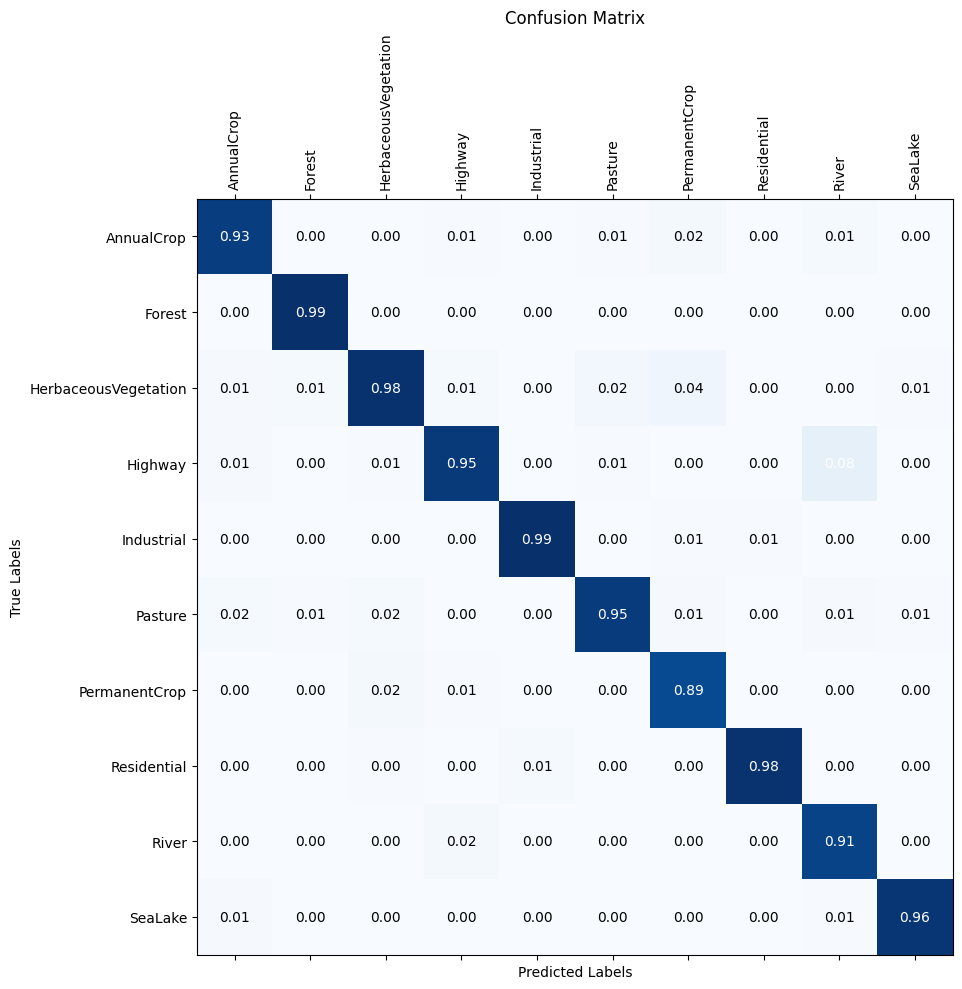

Epoch 21/23, Validation Loss: 0.172, Validation Accuracy: 95.56%, Training Loss: 0.011, Training Accuracy: 99.70%


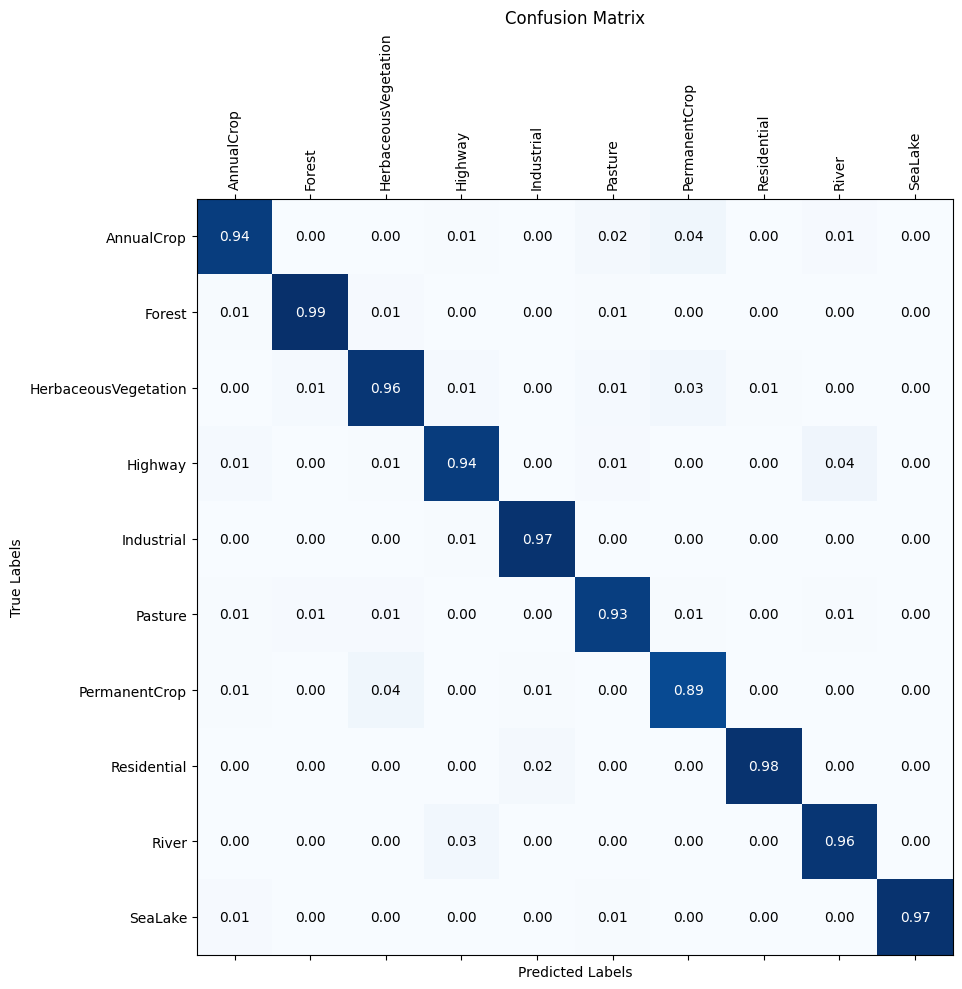

Epoch 22/23, Validation Loss: 0.163, Validation Accuracy: 95.50%, Training Loss: 0.008, Training Accuracy: 99.83%


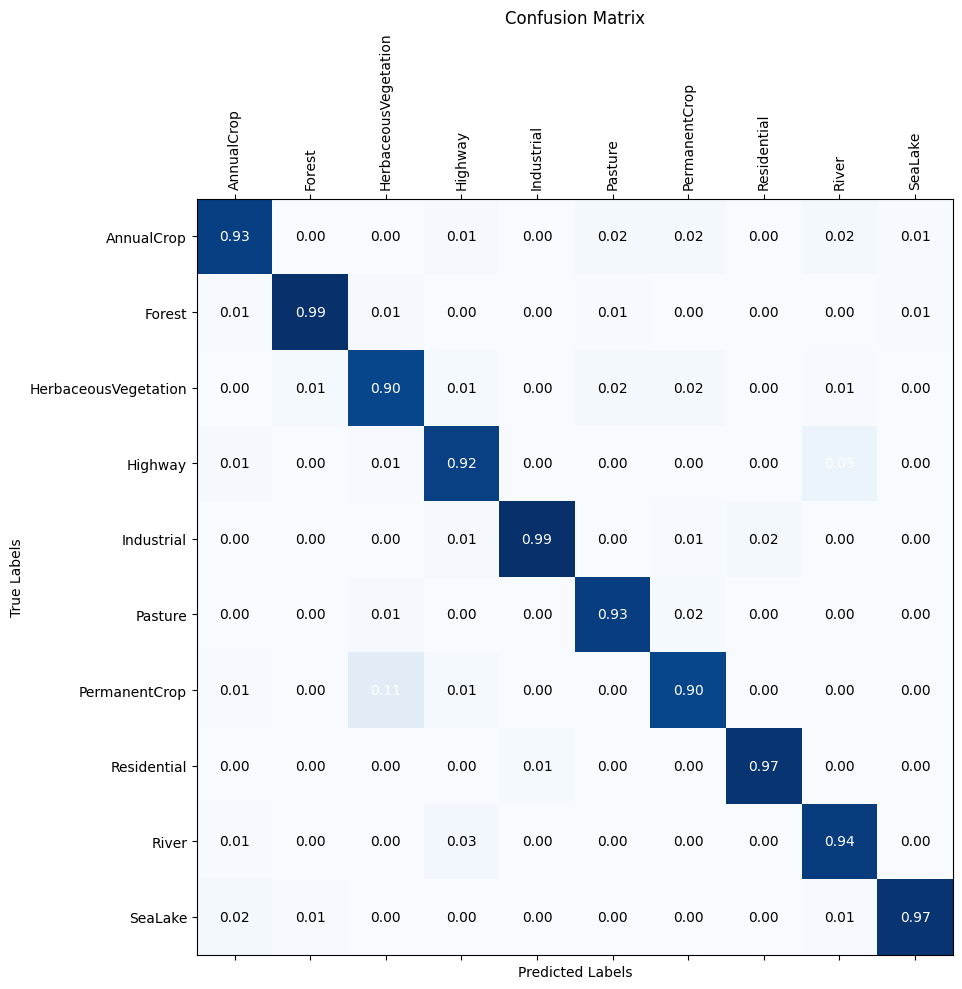

Epoch 23/23, Validation Loss: 0.195, Validation Accuracy: 94.59%, Training Loss: 0.011, Training Accuracy: 99.67%
                      precision    recall  f1-score   support

          AnnualCrop       0.97      0.98      0.97     33281
              Forest       0.98      0.98      0.98     32660
HerbaceousVegetation       0.96      0.97      0.96     33626
             Highway       0.96      0.97      0.97     27255
          Industrial       0.98      0.98      0.98     27347
             Pasture       0.96      0.96      0.96     21206
       PermanentCrop       0.97      0.95      0.96     27784
         Residential       0.98      0.98      0.98     32108
               River       0.97      0.96      0.96     26979
             SeaLake       0.99      0.98      0.98     32154

            accuracy                           0.97    294400
           macro avg       0.97      0.97      0.97    294400
        weighted avg       0.97      0.97      0.97    294400



In [26]:
y_true = []  # True labels
y_pred = []  # Predicted labels

early_stop = 0
wait = 20
best_loss = float('inf')

list_class = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = [], [], [], []

for epoch in range(num_epochs):
    confusion = np.zeros((10, 10))
    occurrences = np.zeros(10)
    train_loss = 0
    valid_loss = 0

    correct_train = 0
    total_train = 0
    correct_valid = 0
    total_valid = 0

    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, 1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == torch.argmax(labels, 1)).sum().item()

        # Append true and predicted labels for this batch
        y_true.extend(list(torch.argmax(labels, 1).cpu().numpy()))
        y_pred.extend(list(predicted.cpu().numpy()))

    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, 1))
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == torch.argmax(labels, 1)).sum().item()
            labels_i = torch.argmax(labels, 1)
            for i, j in zip(predicted, labels_i):
                confusion[i, j] += 1
                occurrences[i] += 1

    train_loss_list.append(train_loss/len(train_loader))
    valid_loss_list.append(valid_loss/len(valid_loader))
    train_acc_list.append(100*correct_train/total_train)
    valid_acc_list.append(100*correct_valid/total_valid)

    # print(confusion)
    for i, n in enumerate(occurences):
      confusion[i, :] = confusion[i, :] / n
    # print(confusion)

    confusion_matrix = np.array(confusion)
    # confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(confusion_matrix, cmap='Blues')
    for i in range(confusion_matrix.shape[0]):
      for j in range(confusion_matrix.shape[1]):
          text = confusion_matrix[i, j]
          ax.text(j, i, f"{text:.2f}", ha='center', va='center', color='white' if text > 0.05 else 'black')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')

    # Set the class labels as tick labels
    ax.set_xticks(range(len(list_class)))
    ax.set_yticks(range(len(list_class)))

    # Set the tick labels
    ax.set_xticklabels(list_class, rotation=90)
    ax.set_yticklabels(list_class)
    plt.tight_layout()

    plt.show()

    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {valid_loss / len(valid_loader):.3f}, Validation Accuracy: {100*correct_valid/total_valid:.2f}%, Training Loss: {train_loss / len(train_loader):.3f}, Training Accuracy: {100*correct_train/total_train:.2f}%')

    if valid_loss < best_loss:
        early_stop = 0
        best_loss = valid_loss
    else:
        early_stop += 1
        if early_stop >= wait:
            print(f"Validation loss didn't improve. {epoch + 1} so EARLY STOPPING")
            print(max(valid_acc_list))
            break

#Printing the classification result (metrics to evaluate the model)
classification_result = classification_report(y_true, y_pred, target_names=list_class)
print(classification_result)


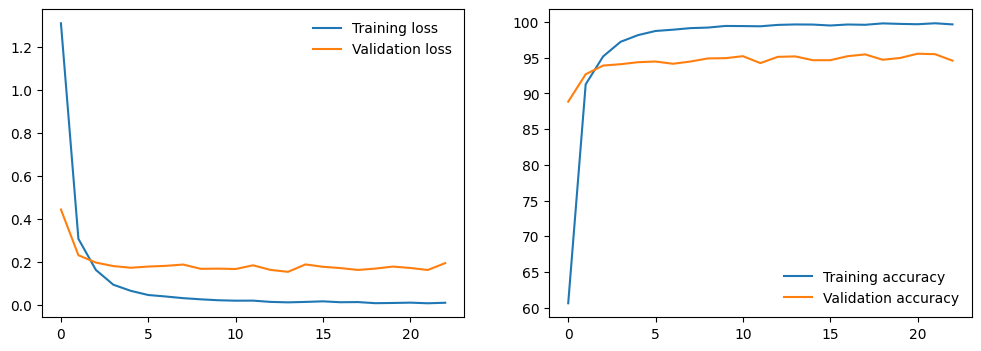

In [27]:
# Plot the training and validation losses and accuracies
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training loss')
plt.plot(valid_loss_list, label='Validation loss')

plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Training accuracy')
plt.plot(valid_acc_list, label='Validation accuracy')

plt.legend(frameon=False)

plt.show()

In [28]:
# Save the model
# torch.save(model.state_dict(), "model_rn_with_" + str(alpha) + ".pt")

In [29]:
# # Test on X_train_val

# # Load the model
# model = SimpleCNN().to(device)
# model.load_state_dict(torch.load("model_rn_with_" + str(alpha) + ".pt"))

# test_loader = DataLoader(TensorDataset(torch.stack([transform(i) for i in X_valid_PIL])), batch_size=batch_size, shuffle=False)

# model.eval()

# with torch.no_grad():
#     correct = 0
#     total = 0
#     y_list = []
#     for img in test_loader:
#         images = img[0].to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         y_list.append(predicted.cpu().numpy())
#     y_list = np.concatenate(y_list)
#     print("y_list", len(y_list))
#     print("torch.argmax(torch.Tensor(y_valid), 1)", len(torch.argmax(torch.Tensor(y_valid), 1).numpy()))
#     print("=",y_list==torch.argmax(torch.Tensor(y_valid), 1).numpy())
#     # print('Accuracy on the train dataset : %d %%' % (100 * np.mean(y_list == torch.argmax(torch.Tensor(y_valid), 1).numpy())))

In [30]:
# np.save("y_list_" + str(alpha) + ".npy", y_list)
# y_list = np.load("y_list" + str(alpha) + ".npy")

In [31]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # Compute the confusion matrix
# cm = confusion_matrix(torch.argmax(torch.Tensor(y_valid), 1).numpy(), y_list)

# # Normalize the confusion matrix
# cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# # Define the class labels
# class_labels = enc.categories_[0]

# # Plot the confusion matrix
# plt.figure(figsize=(10, 10))
# sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.xticks(rotation=45)
# plt.show()

# Create Your Submission

In [22]:
# Function to create a submission file
def create_submission(predictions):
    assert predictions.shape == (7000, 1), f"Wrong shape for your prediction file : {predictions.shape} instead of (7000, 1)"
    with open('CATONI, CHEN, LYAMOUDI, RAMASSAMY-MOUTOUSSAMY.npy', 'wb') as f:
      np.save(f, predictions)
    print("File predictions.npy created !")

In [23]:
# Generate predictions
bs = 35
predictions = np.ones((X_test_tensor.shape[0],10))
for i in range(X_test_tensor.shape[0]//bs):
  predictions[bs*i:bs*(i+1),:] = model(X_test_tensor[bs*i:bs*(i+1)].to(device)).cpu().detach().numpy()
print(predictions[:5])

# Get labels
predictions = encoder.inverse_transform(predictions)
print(predictions[:5])

# Create a submission using the provided function
NAME = "CATONI, CHEN, LYAMOUDI, RAMASSAMY-MOUTOUSSAMY"
NUMBER = 1
create_submission(predictions)

[[-1.07178891 -1.96767867 -3.77575636 -3.37491703 -3.08626223  6.26687479
  -2.27123046 -3.82627368 -3.04483819 -4.50226116]
 [-5.13562346 -3.87299156 -5.87122202 -2.75659704  7.42722893 -3.01584744
  -2.52448273 -2.42108941 -4.47023487 -4.19519043]
 [-6.20276356 -6.96192503 -4.54912043 -5.17114067 -3.70064139 -4.7169323
  11.29366112 -4.95090389 -7.93201542 -9.84978008]
 [-3.46258497  6.37393379 -2.3789525  -4.0189352  -4.10509205 -2.85130119
  -2.53901529 -2.81215024 -3.48808169 -1.54605591]
 [-3.51764417 -4.47824478 -2.36336493 -3.47714233 -3.83266282 -4.46934128
  -3.11665702 -2.42656136  7.65207958 -4.81988764]]
[['Pasture']
 ['Industrial']
 ['PermanentCrop']
 ['Forest']
 ['River']]
File predictions.npy created !
